# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import scikitplot as skplt
import seaborn as sns
import datetime

In [2]:
#pip install xgboost

In [3]:
from sklearn.preprocessing import StandardScaler #standarization
from sklearn.preprocessing import MinMaxScaler #Normalization

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
#from lazypredict.Supervised import LazyClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from sklearn.svm import SVC

from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn import metrics

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#df = pd.read_csv("DataCoSupplyChainDataset.csv",encoding='latin-1')
df = pd.read_csv("/content/drive/Shareddrives/Data_240_project/Code/supply.csv",encoding='latin-1')

# Data Preprocessing

In [6]:
# To check number rows in each category
row_count = pd.DataFrame()
row_count['Count'] = df['Order Status'].value_counts()
row_count

,Count
COMPLETE,59491
PENDING_PAYMENT,39832
PROCESSING,21902
PENDING,20227
CLOSED,19616
ON_HOLD,9804
SUSPECTED_FRAUD,4062
CANCELED,3692
PAYMENT_REVIEW,1893


In [7]:
df['order date (DateOrders)'] = pd.to_datetime(df['order date (DateOrders)'])
df['shipping date (DateOrders)'] = pd.to_datetime(df['shipping date (DateOrders)'])
df['order date (DateOrders)'] = df['order date (DateOrders)'].astype('datetime64').dt.day_of_week
df['shipping date (DateOrders)'] = df['shipping date (DateOrders)'].astype('datetime64').dt.day_of_week

In [8]:
irrev_cols = ['Category Name', 'Customer Email', 'Customer Fname', 'Customer Lname', 'Customer Password', 
              'Customer Street', 'Department Name', 'Order Zipcode', 'Product Description', 'Product Image']
df = df.drop(columns = irrev_cols)

In [9]:
cols = ['Type','Delivery Status', 'Customer City', 'Customer Country', 'Customer Segment', 'Customer State' , 
        'Market', 'Order City', 'Order Country', 'Order Region', 'Order State', 'Product Name'
        , 'Shipping Mode']
df[cols] = df[cols].apply(LabelEncoder().fit_transform)

Data Cleaning

In [10]:
df = df.dropna()
df.drop_duplicates(inplace=True)

In [11]:
df.isnull().sum().head(1)

Type    0
dtype: int64

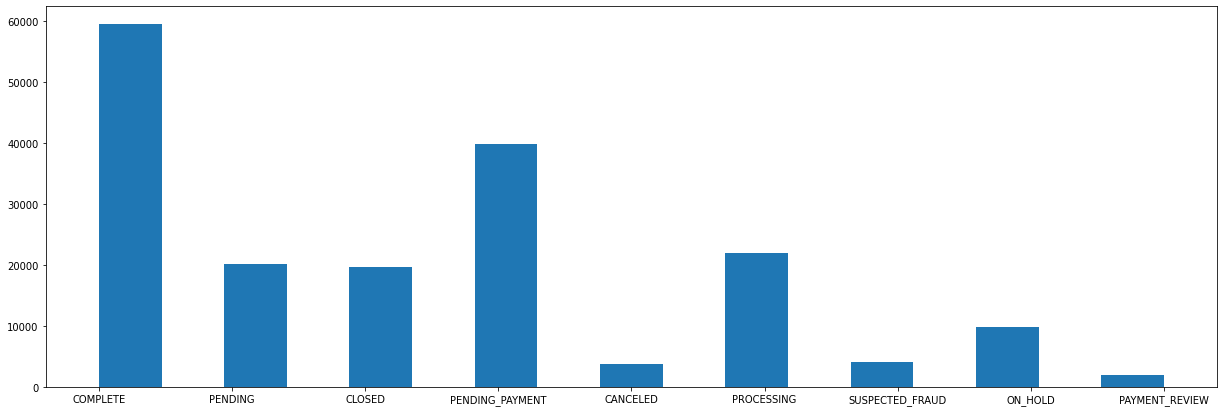

In [12]:
plt.figure(figsize=(21, 7))
plt.hist(df['Order Status'],bins = int(17))
plt.show()

In [13]:
df['Order Status']=df['Order Status'].replace(['COMPLETE','PENDING','PROCESSING','CANCELED','PENDING_PAYMENT','ON_HOLD','CLOSED','PAYMENT_REVIEW' ],[1,1,1,1,1,1,1,1])
df['Order Status']=df['Order Status'].replace(['SUSPECTED_FRAUD'],[0])

In [14]:
cols = np.percentile(df,[])
Q1 = df[cols].quantile(0.25)
Q3 = df[cols].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df[cols] < (Q1 - 1.5 * IQR)) |(df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [15]:
outputdf=df['Order Status']

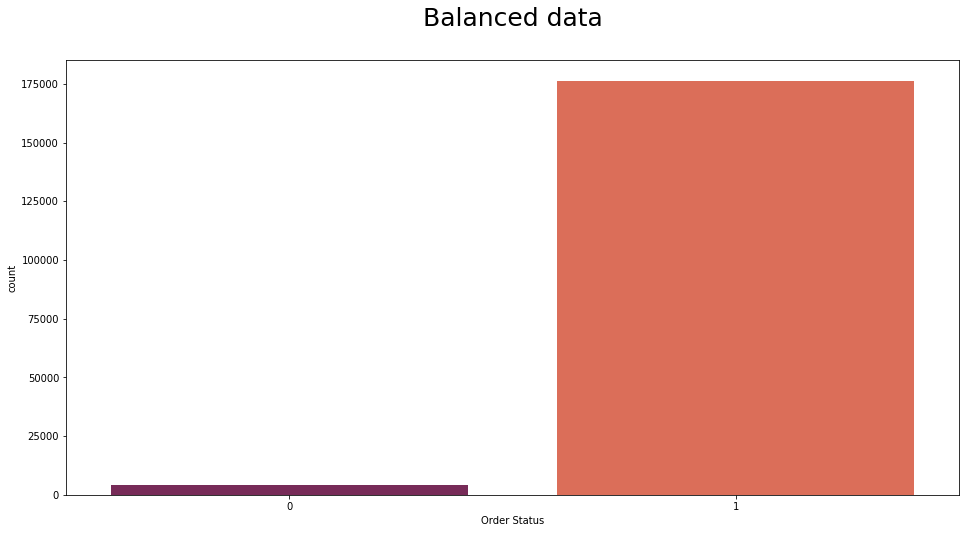

In [16]:
plt.figure(figsize=(16,8))
sns.countplot(data=df, x="Order Status", palette='rocket')
plt.title("Balanced data\n", fontsize=25)
plt.show()

In [17]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest,chi2

In [18]:
scaler = MinMaxScaler()

In [19]:
scal_x = scaler.fit_transform(df.drop(columns=['Order Status']))

Feature Selection

In [20]:
x_10best = SelectKBest(chi2, k=10).fit(scal_x,outputdf)

In [21]:
mask = x_10best.get_support() #list of booleans for selected features
new_feat = [] 
for bool, feature in zip(mask, df.drop(columns=['Order Status']).columns):
    if bool:
        new_feat.append(feature)
print('The best features are:{}'.format(new_feat))

The best features are:['Type', 'Delivery Status', 'Late_delivery_risk', 'Customer Country', 'Customer Id', 'Customer Segment', 'Customer Zipcode', 'Order Customer Id', 'order date (DateOrders)', 'Order Region']


In [22]:
kbest_x = df[['Type', 'Delivery Status', 'Late_delivery_risk', 'Customer Country', 'Customer Id', 
            'Customer Segment', 'Customer Zipcode', 'Order Customer Id', 'order date (DateOrders)', 'Order Region']]

In [23]:
kbest_x = scaler.fit_transform(kbest_x)

# Data Preparation

**Setting aside a validation set that is stratified along the output so that it has the same distribution as the original dataset**

In [24]:
X_kb_train, X_kb_val, y_kb_train, y_kb_val = train_test_split(kbest_x, outputdf, test_size = .2, random_state =1, stratify=outputdf)

**Data Transformation** 

**Oversampling with SMOTE to train the models on balanced data**

In [25]:
from imblearn.over_sampling import SMOTE #smote

In [26]:
sm = SMOTE(random_state=42)

In [27]:
x_kb_smo, y_kb_smo = sm.fit_resample(X_kb_train,y_kb_train)

In [28]:
newx = pd.DataFrame(x_kb_smo)
newx['Order Status'] = y_kb_smo

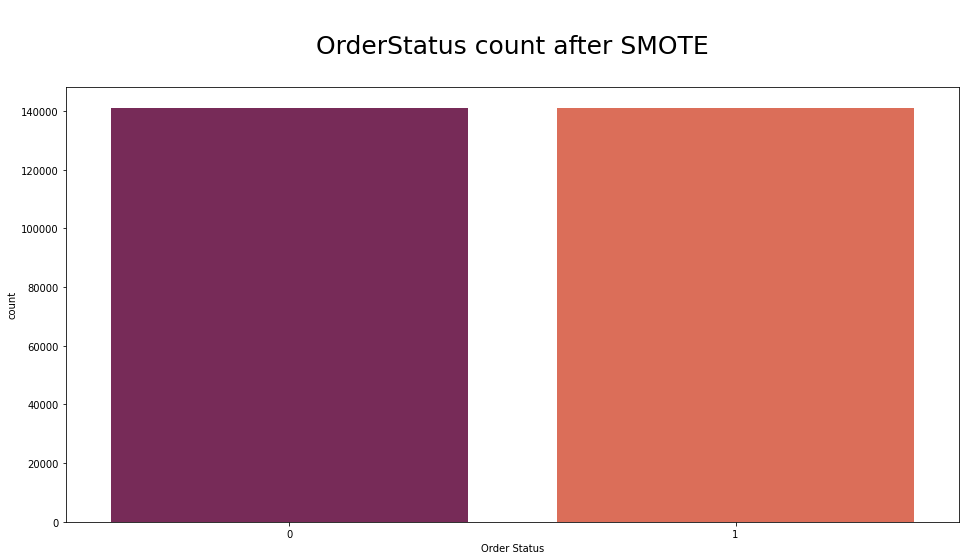

In [29]:
plt.figure(figsize=(16,8))
sns.countplot(data=newx, x="Order Status", palette='rocket')
plt.title("\nOrderStatus count after SMOTE\n", fontsize=25)
plt.show()

In [30]:
X_kb_train, X_kb_test, y_kb_train, y_kb_test = train_test_split(x_kb_smo, y_kb_smo, test_size=0.1875, random_state=1)

# Modeling & Test Set Performance with 10 Best Features (Best Performer)

In [31]:
tree_kb = DecisionTreeClassifier(criterion = 'gini', max_depth = 5)
tree_kb.fit(X_kb_train,y_kb_train)
y_dt_kb_pred = tree_kb.predict(X_kb_test)

In [32]:
print(classification_report(y_dt_kb_pred, y_kb_test))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     26872
           1       0.98      1.00      0.99     26064

    accuracy                           0.99     52936
   macro avg       0.99      0.99      0.99     52936
weighted avg       0.99      0.99      0.99     52936



In [33]:
rfc_kb = RandomForestClassifier()
rfc_kb.fit(X_kb_train, y_kb_train)
y_rfc_kb_pred = rfc_kb.predict(X_kb_test)

In [34]:
print(classification_report(y_rfc_kb_pred, y_kb_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26418
           1       1.00      1.00      1.00     26518

    accuracy                           1.00     52936
   macro avg       1.00      1.00      1.00     52936
weighted avg       1.00      1.00      1.00     52936



In [35]:
#svmc_kb = svm.SVC(C=.75, kernel='linear')
#svmc_kb.fit(X_kb_train,y_kb_train)
#ysvm_kb_pred = svmc_kb.predict(X_kb_test)

In [36]:
#print(classification_report(ysvm_kb_pred, y_kb_test))

In [37]:
gnb_kb = GaussianNB()
gnb_kb.fit(X_kb_train,y_kb_train)
ygnb_kb_pred = gnb_kb.predict(X_kb_test)

In [38]:
print(classification_report(ygnb_kb_pred, y_kb_test))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     26873
           1       0.98      1.00      0.99     26063

    accuracy                           0.99     52936
   macro avg       0.99      0.99      0.99     52936
weighted avg       0.99      0.99      0.99     52936



In [39]:
xgb_kb = XGBClassifier()
xgb_kb.fit(X_kb_train, y_kb_train)
yxgb_kb_pred = xgb_kb.predict(X_kb_test)


In [40]:
print(classification_report(yxgb_kb_pred, y_kb_test))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     26873
           1       0.98      1.00      0.99     26063

    accuracy                           0.99     52936
   macro avg       0.99      0.99      0.99     52936
weighted avg       0.99      0.99      0.99     52936



# Validation Set Performance

**Decision Tree**

In [41]:
dt_kb_val_pred = tree_kb.predict(X_kb_val)

In [42]:
print(classification_report(dt_kb_val_pred, y_kb_val))

              precision    recall  f1-score   support

           0       1.00      0.53      0.69      1544
           1       0.98      1.00      0.99     34560

    accuracy                           0.98     36104
   macro avg       0.99      0.76      0.84     36104
weighted avg       0.98      0.98      0.98     36104



**Random Forest**

In [43]:
y_rfc_val_kb_pred = rfc_kb.predict(X_kb_val)

In [44]:
print(classification_report(y_rfc_val_kb_pred, y_kb_val))

              precision    recall  f1-score   support

           0       0.98      0.87      0.93       914
           1       1.00      1.00      1.00     35190

    accuracy                           1.00     36104
   macro avg       0.99      0.94      0.96     36104
weighted avg       1.00      1.00      1.00     36104



**XGBoost**

In [45]:
yxgb_kb_val_pred = xgb_kb.predict(X_kb_val)

In [46]:
print(classification_report(yxgb_kb_val_pred, y_kb_val))

              precision    recall  f1-score   support

           0       1.00      0.53      0.69      1546
           1       0.98      1.00      0.99     34558

    accuracy                           0.98     36104
   macro avg       0.99      0.76      0.84     36104
weighted avg       0.98      0.98      0.98     36104



**Gaussian Naive Bayes**

In [47]:
ygnb_val_kb_pred = gnb_kb.predict(X_kb_val)

In [48]:
print(classification_report(ygnb_val_kb_pred, y_kb_val))

              precision    recall  f1-score   support

           0       1.00      0.53      0.69      1546
           1       0.98      1.00      0.99     34558

    accuracy                           0.98     36104
   macro avg       0.99      0.76      0.84     36104
weighted avg       0.98      0.98      0.98     36104



# Confusion Matrices - Test Sets

**Decision Tree - Test Set**

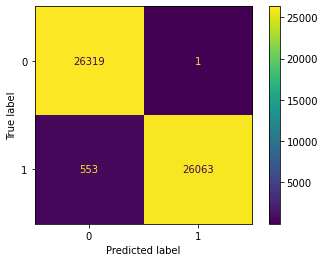

In [49]:
dt_cm = confusion_matrix(y_kb_test, y_dt_kb_pred, labels=tree_kb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=dt_cm, display_labels=tree_kb.classes_)
disp.plot()
plt.show()

**Random Forest - Test Set**

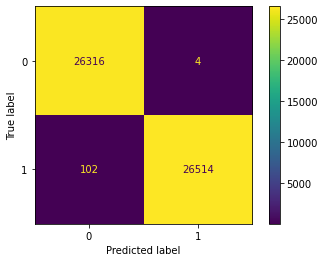

In [50]:
rfc_cm = confusion_matrix(y_kb_test,y_rfc_kb_pred, labels=rfc_kb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=rfc_cm, display_labels=rfc_kb.classes_)
disp.plot()
plt.show()

**XGBoost - Test Set**

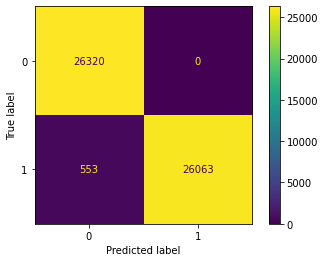

In [51]:
xgb_cm = confusion_matrix(y_kb_test,yxgb_kb_pred , labels=xgb_kb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=xgb_cm, display_labels=rfc_kb.classes_)
disp.plot()
plt.show()

**Gaussian Naive Bayes - Test Set**

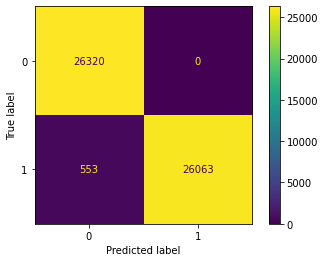

In [52]:
gnb_cm = confusion_matrix(y_kb_test,ygnb_kb_pred , labels=gnb_kb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=gnb_cm, display_labels=rfc_kb.classes_)
disp.plot()
plt.show()

# Confusion Matrices - Validation Sets

**Decision Tree - Validation Set**

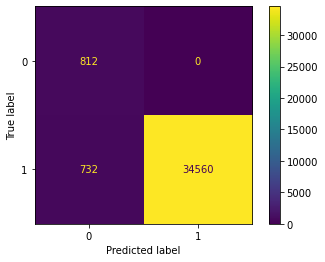

In [53]:
dt_val_cm = confusion_matrix(y_kb_val, dt_kb_val_pred, labels=tree_kb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=dt_val_cm, display_labels=tree_kb.classes_)
disp.plot()
plt.show()

**Random Forest - Validation Set**

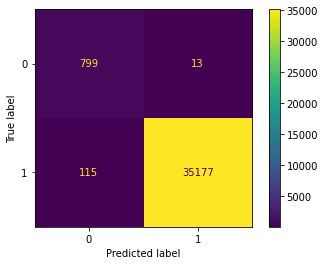

In [54]:
rfc_val_cm = confusion_matrix(y_kb_val,y_rfc_val_kb_pred, labels=rfc_kb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=rfc_val_cm, display_labels=rfc_kb.classes_)
disp.plot()
plt.show()

**XGBoost - Validation Set**

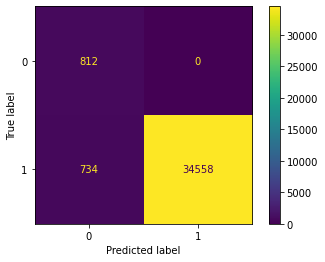

In [55]:
xgb_val_cm = confusion_matrix(y_kb_val,yxgb_kb_val_pred , labels=xgb_kb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=xgb_val_cm, display_labels=rfc_kb.classes_)
disp.plot()
plt.show()

**Gaussian Naive Bayes - Validation Set**

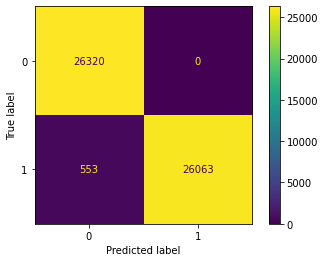

In [56]:
gnb_val_cm = confusion_matrix(y_kb_val,ygnb_val_kb_pred , labels=gnb_kb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=gnb_cm, display_labels=rfc_kb.classes_)
disp.plot()
plt.show()

# Testing 15 Features 

In [57]:
x_15best = SelectKBest(chi2, k=15).fit(scal_x,outputdf)

In [58]:
mask = x_15best.get_support() #list of booleans for selected features
new_feat = [] 
for bool, feature in zip(mask, df.drop(columns=['Order Status']).columns):
    if bool:
        new_feat.append(feature)
print('The best 15 features are:{}'.format(new_feat))

The best 15 features are:['Type', 'Delivery Status', 'Late_delivery_risk', 'Customer Country', 'Customer Id', 'Customer Segment', 'Customer State', 'Customer Zipcode', 'Order City', 'Order Country', 'Order Customer Id', 'order date (DateOrders)', 'Order Region', 'Order State', 'Shipping Mode']


In [59]:
kbest15_x = df[['Type', 'Delivery Status', 'Late_delivery_risk', 'Customer Country', 'Customer Id', 
                'Customer Segment', 'Customer State', 'Customer Zipcode', 'Order City', 'Order Country', 
                'Order Customer Id', 'order date (DateOrders)', 'Order Region', 'Order State', 'Shipping Mode']]

In [60]:
X_kb15_train, X_kb15_val, y_kb15_train, y_kb15_val = train_test_split(kbest15_x, outputdf, test_size = .2, random_state =1, stratify=outputdf)

In [61]:
x_kb15_smo, y_kb15_smo = sm.fit_resample(X_kb15_train,y_kb15_train)

In [62]:
X_kb15_train, X_kb15_test, y_kb15_train, y_kb15_test = train_test_split(x_kb15_smo, y_kb15_smo, test_size=0.1875, random_state=1)

In [63]:
rfc_kb15 = RandomForestClassifier()
rfc_kb15.fit(X_kb15_train, y_kb15_train)
y_rfc_kb15_pred = rfc_kb15.predict(X_kb15_test)

In [64]:
print(classification_report(y_rfc_kb15_pred, y_kb15_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26413
           1       1.00      1.00      1.00     26523

    accuracy                           1.00     52936
   macro avg       1.00      1.00      1.00     52936
weighted avg       1.00      1.00      1.00     52936



In [65]:
y_rfc_val_kb15_pred = rfc_kb15.predict(X_kb15_val)

In [66]:
print(classification_report(y_rfc_val_kb15_pred, y_kb15_val))

              precision    recall  f1-score   support

           0       0.97      0.87      0.92       902
           1       1.00      1.00      1.00     35202

    accuracy                           1.00     36104
   macro avg       0.98      0.94      0.96     36104
weighted avg       1.00      1.00      1.00     36104



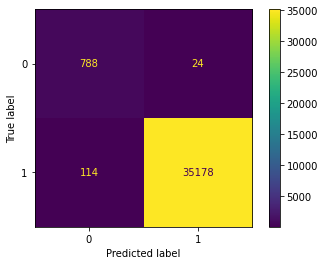

In [67]:
rfc_val15_cm = confusion_matrix(y_kb15_val,y_rfc_val_kb15_pred, labels=rfc_kb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=rfc_val15_cm, display_labels=rfc_kb.classes_)
disp.plot()
plt.show()

# Testing 5 Features 

In [68]:
x_5best = SelectKBest(chi2, k=5).fit(scal_x,outputdf)

In [69]:
mask = x_5best.get_support() #list of booleans for selected features
new_feat = [] 
for bool, feature in zip(mask, df.drop(columns=['Order Status']).columns):
    if bool:
        new_feat.append(feature)
print('The best 5 features are:{}'.format(new_feat))

The best 5 features are:['Type', 'Delivery Status', 'Late_delivery_risk', 'Customer Country', 'Customer Segment']


In [70]:
kbest5_x = df[['Type', 'Delivery Status', 'Late_delivery_risk', 'Customer Country', 'Customer Segment']]

In [71]:
X_kb5_train, X_kb5_val, y_kb5_train, y_kb5_val = train_test_split(kbest5_x, outputdf, test_size = .2, random_state =1, stratify=outputdf)

In [72]:
x_kb5_smo, y_kb5_smo = sm.fit_resample(X_kb5_train,y_kb5_train)

In [73]:
X_kb5_train, X_kb5_test, y_kb5_train, y_kb5_test = train_test_split(x_kb5_smo, y_kb5_smo, test_size=0.1875, random_state=1)

In [74]:
rfc_kb5 = RandomForestClassifier()
rfc_kb5.fit(X_kb5_train, y_kb5_train)
y_rfc_kb5_pred = rfc_kb5.predict(X_kb5_test)

In [75]:
print(classification_report(y_rfc_kb5_pred, y_kb5_test))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     26873
           1       0.98      1.00      0.99     26063

    accuracy                           0.99     52936
   macro avg       0.99      0.99      0.99     52936
weighted avg       0.99      0.99      0.99     52936



In [76]:
y_rfc_val_kb5_pred = rfc_kb5.predict(X_kb5_val)

In [77]:
print(classification_report(y_rfc_val_kb5_pred, y_kb5_val))

              precision    recall  f1-score   support

           0       1.00      0.53      0.69      1546
           1       0.98      1.00      0.99     34558

    accuracy                           0.98     36104
   macro avg       0.99      0.76      0.84     36104
weighted avg       0.98      0.98      0.98     36104



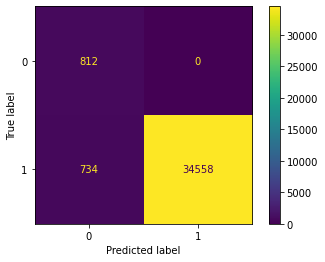

In [78]:
rfc_val5_cm = confusion_matrix(y_kb5_val,y_rfc_val_kb5_pred, labels=rfc_kb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=rfc_val5_cm, display_labels=rfc_kb.classes_)
disp.plot()
plt.show()

# Testing 25 Features

In [79]:
x_25best = SelectKBest(chi2, k=25).fit(scal_x,outputdf)

In [80]:
mask = x_25best.get_support() #list of booleans for selected features
new_feat = [] 
for bool, feature in zip(mask, df.drop(columns=['Order Status']).columns):
    if bool:
        new_feat.append(feature)
print('The best 25 features are:{}'.format(new_feat))

The best 25 features are:['Type', 'Days for shipment (scheduled)', 'Delivery Status', 'Late_delivery_risk', 'Category Id', 'Customer City', 'Customer Country', 'Customer Id', 'Customer Segment', 'Customer State', 'Customer Zipcode', 'Latitude', 'Longitude', 'Order City', 'Order Country', 'Order Customer Id', 'order date (DateOrders)', 'Order Id', 'Order Item Discount Rate', 'Order Item Id', 'Order Region', 'Order State', 'Product Category Id', 'shipping date (DateOrders)', 'Shipping Mode']


In [81]:
kbest25_x = df[['Type', 'Days for shipment (scheduled)', 'Delivery Status', 
               'Late_delivery_risk', 'Category Id', 'Customer City', 'Customer Country', 'Customer Id', 
               'Customer Segment', 'Customer State', 'Customer Zipcode', 'Latitude', 'Longitude', 'Order City', 
               'Order Country', 'Order Customer Id', 'order date (DateOrders)', 'Order Id', 
               'Order Item Discount Rate', 'Order Item Id', 'Order Region', 'Order State', 
               'Product Category Id', 'shipping date (DateOrders)', 'Shipping Mode']]

In [82]:
X_kb25_train, X_kb25_val, y_kb25_train, y_kb25_val = train_test_split(kbest25_x, outputdf, test_size = .2, random_state =1, stratify=outputdf)

In [83]:
x_kb25_smo, y_kb25_smo = sm.fit_resample(X_kb25_train,y_kb25_train)

In [84]:
X_kb25_train, X_kb25_test, y_kb25_train, y_kb25_test = train_test_split(x_kb25_smo, y_kb25_smo, test_size=0.1875, random_state=1)

In [85]:
rfc_kb25 = RandomForestClassifier()
rfc_kb25.fit(X_kb25_train, y_kb25_train)
y_rfc_kb25_pred = rfc_kb25.predict(X_kb25_test)

In [86]:
print(classification_report(y_rfc_kb25_pred, y_kb25_test))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     26651
           1       0.99      1.00      0.99     26285

    accuracy                           0.99     52936
   macro avg       0.99      0.99      0.99     52936
weighted avg       0.99      0.99      0.99     52936



In [87]:
y_rfc_val_kb25_pred = rfc_kb25.predict(X_kb25_val)

In [88]:
print(classification_report(y_rfc_val_kb25_pred, y_kb25_val))

              precision    recall  f1-score   support

           0       0.92      0.62      0.74      1217
           1       0.99      1.00      0.99     34887

    accuracy                           0.99     36104
   macro avg       0.95      0.81      0.87     36104
weighted avg       0.98      0.99      0.98     36104



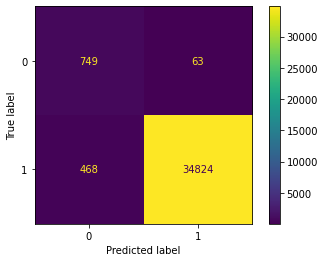

In [89]:
rfc_val25_cm = confusion_matrix(y_kb25_val,y_rfc_val_kb25_pred, labels=rfc_kb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=rfc_val25_cm, display_labels=rfc_kb.classes_)
disp.plot()
plt.show()

**XGBoost**

In [90]:
xgb_kb25 = XGBClassifier()
xgb_kb25.fit(X_kb25_train, y_kb25_train)
yxgb_kb25_pred = xgb_kb25.predict(X_kb25_test)

In [91]:
print(classification_report(yxgb_kb25_pred, y_kb25_test))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     26862
           1       0.98      1.00      0.99     26074

    accuracy                           0.99     52936
   macro avg       0.99      0.99      0.99     52936
weighted avg       0.99      0.99      0.99     52936



In [92]:
yxgb_val_kb25_pred = xgb_kb25.predict(X_kb25_val)

In [93]:
print(classification_report(yxgb_val_kb25_pred, y_kb25_val))

              precision    recall  f1-score   support

           0       1.00      0.53      0.69      1538
           1       0.98      1.00      0.99     34566

    accuracy                           0.98     36104
   macro avg       0.99      0.76      0.84     36104
weighted avg       0.98      0.98      0.98     36104



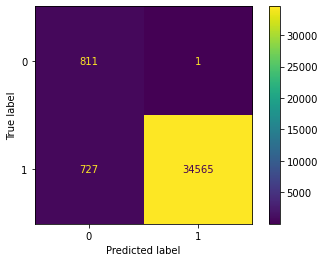

In [94]:
xgb_val25_cm = confusion_matrix(y_kb25_val,yxgb_val_kb25_pred, labels=xgb_kb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=xgb_val25_cm, display_labels=xgb_kb.classes_)
disp.plot()
plt.show()